In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
from sklearn.decomposition import PCA

import pickle as pck

## MD step function

## 1 - 2d double well: Potential definition and visualisation

In [3]:
m = 1.0
# potential
def Vpot(r):
    return (r[0]**2 - 1.5)**2 + 0.05 * r[1]**2

# dV/dx
def Vpot_dx(r):
    return 4 * (r[0]**2 - 1.5) * r[0]

# dV/dy
def Vpot_dy(r):
    return 2 * 0.05 * r[1]

# compute kinetic energy
def Ekin(v):
    return 1/2 * m * np.sum(v**2)

# check if particle is in A or B
def in_A(r):
    return r[0] < -.8
    
def in_B(r):
    return r[0] > .8

In [4]:
from numpy.random import default_rng
import numpy as np

# MD step
rng = default_rng(23)


def mdstep(r, v, f, dt, lc):
    """MD step using Langevin dynamics

    Parameters
    ----------
    r:
        positions
    v:
        velocities
    f:
        forces
    dt:
        time step
    lc:
        coefficients for Langevin dynamics

    Return
    ---------
    r:
        updated positions
    v:
        updated velocities
    f:
        updated forces

    """

    # mass is set to 1.0 here, does not explicitly appear in the equations

    # langevin thermo, 1st half step
    v = lc[0] * v + lc[1] * rng.standard_normal(size=2)

    # Verlet part of MD step
    v = v + 0.5 * f * dt
    r = r + dt * v

    # compute forces for new position, dVdx and dVdy are the partial derivatives wrt x and y
    f = np.array([-Vpot_dx(r), -Vpot_dy(r)])

    v = v + 0.5 * f * dt

    # langevin thermo, 2nd half step
    v = lc[0] * v + lc[1] * rng.standard_normal(size=2)

    return r, v, f

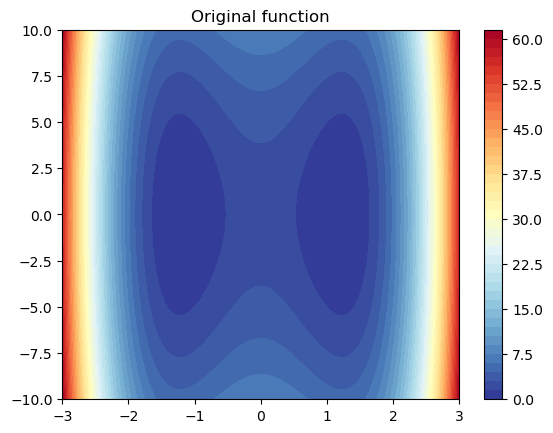

In [8]:
x = np.linspace(-3, 3, 1000)
y = np.linspace(-10, 10, 1000)

X, Y = np.meshgrid(x,y)

V = Vpot((X,Y))
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, V, levels=50, cmap='RdYlBu_r')
cbar = fig.colorbar(cs)
plt.title('Original function')
plt.show()

In [9]:
dt = .05
beta = 3.0
gamma = 1.0
lgamma = 1.0
m = 1.0
c1 = np.exp(-lgamma * dt / 2.0)
c2 = np.sqrt((1.0 - (c1 * c1)) / beta)
lc = np.array([c1, c2])

traj = []

x = np.random.uniform(-6,6)
y = np.random.uniform(-6,6)
r = np.array([x, y])
v = np.array(
[
np.sqrt(1.0 / beta) * rng.standard_normal(),
np.sqrt(1.0 / beta) * rng.standard_normal(),
]
)
sum_Ekin = 0.0
count = 0
scale = np.sqrt(1.0 / beta / Ekin(v))
v = v * scale
f = np.array([-Vpot_dx(r), -Vpot_dy(r)])
for _ in range(10):
    for _ in range(10**4):
        for _ in range(10):
            r, v, f = mdstep(r, v, f, dt, lc)
            count = count + 1
            sum_Ekin = sum_Ekin + Ekin(v)
        traj.append(r)
    print(f"x = {r[0]:.3f}, y = {r[1]:.3f}, average beta = {1.0/(sum_Ekin/count):.3f}, A = {in_A(r)}, B = {in_B(r)}")
        


x = 1.217, y = 0.901, average beta = 2.920, A = False, B = True
x = -1.197, y = 0.956, average beta = 2.931, A = True, B = False
x = -1.422, y = 2.037, average beta = 2.957, A = True, B = False
x = -1.234, y = 4.203, average beta = 2.987, A = True, B = False
x = 1.192, y = -2.071, average beta = 3.000, A = False, B = True
x = 1.181, y = -1.674, average beta = 3.002, A = False, B = True
x = -0.958, y = 0.151, average beta = 2.998, A = True, B = False
x = 1.135, y = 0.388, average beta = 2.996, A = False, B = True
x = 1.092, y = 0.526, average beta = 2.994, A = False, B = True
x = -1.250, y = 2.449, average beta = 2.993, A = True, B = False


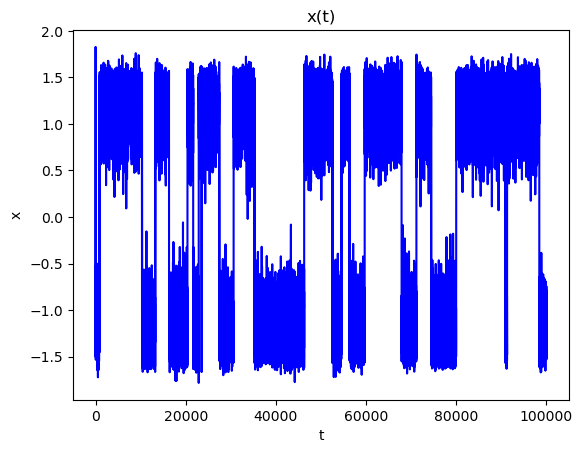

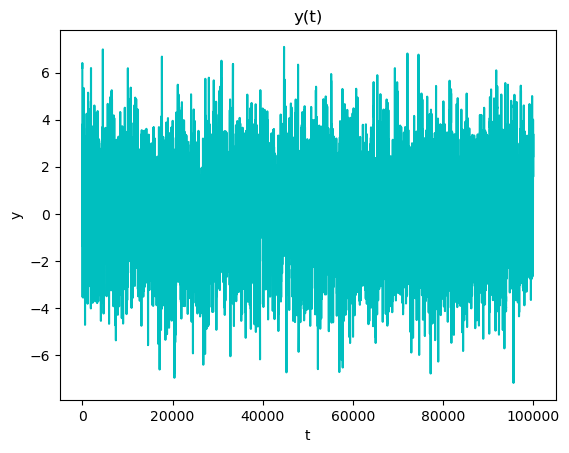

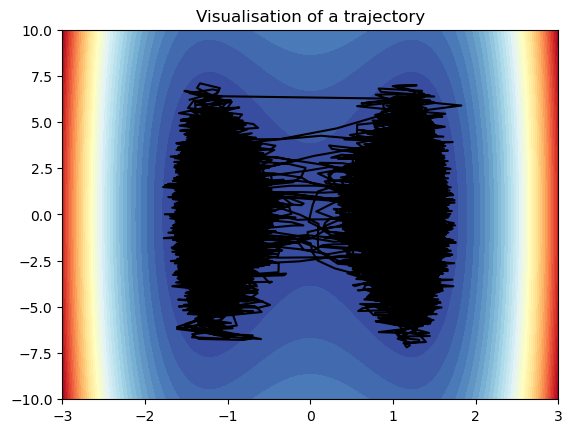

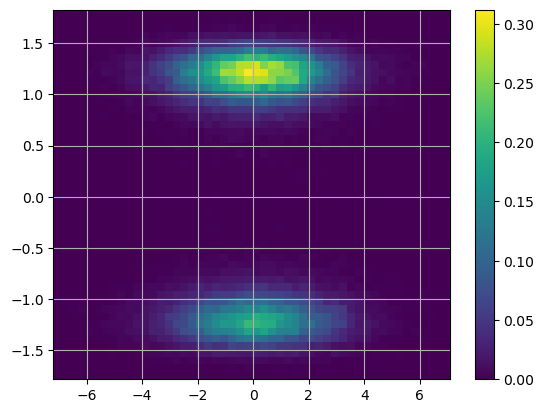

In [10]:
traj = np.array(traj)

# Plot x and y as a function of time
plt.figure()
plt.plot(traj[:, 0], color='b')
plt.xlabel('t')
plt.ylabel('x')
plt.title('x(t)')
plt.show()

plt.figure()
plt.plot(traj[:, 1], color='c')
plt.xlabel('t')
plt.ylabel('y')
plt.title('y(t)')
plt.show


# Visualising trajectory
V = Vpot((X,Y))
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, V, levels=50, cmap='RdYlBu_r')
ax.plot(traj[:, 0], traj[:, 1], color='k')
plt.title('Visualisation of a trajectory')
plt.show()

# Distribution of points in the xy-plane ## TODO: strange distribution
H, y_edges, x_edges = np.histogram2d(traj[:, 0], traj[:, 1], bins=50, density=True)
fig, ax = plt.subplots()
cs = ax.pcolormesh(x_edges, y_edges, H)
cbar = fig.colorbar(cs)

ax.grid()
plt.show()


## 1.3 - PCA


In [11]:
def pca(X, num_components):
    """ Performs PCA for a given number of components. Returns reduced data and eigenvectors (principal components).

    Parameters:
    -----------
    X : Array to perform PCA on.
    num_components : Number of principal components of interest.
    """
    # subtract mean
    x = X - np.mean(X, axis=0)

    # covariance matrix
    cov_mat = np.cov(x, rowvar=False)

    # Diagonalize covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov_mat)

    # Sort
    sorted_ids = np.argsort(eigvals)[::-1]
    eigvecs_sorted = eigvecs[:, sorted_ids]

    # Select requested eigenvectors
    eigvecs_selected = eigvecs_sorted[:, 0:num_components]

    # Project data onto eigenvectors
    X_projected = np.dot(eigvecs_selected.transpose(), x.transpose()).transpose()

    return X_projected, eigvecs_selected

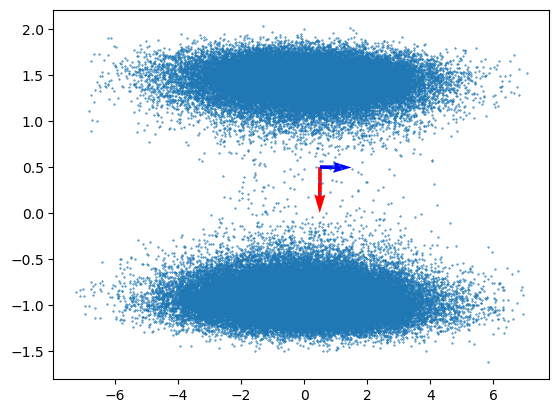

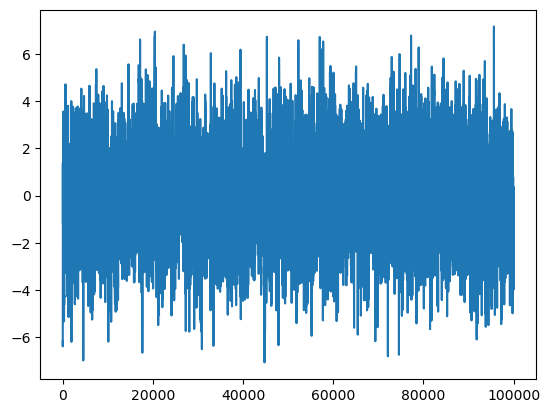

In [13]:
traj_reduced, evecs = pca(traj, 2)
origin = np.array([[0.5, 0.5], [0.5, 0.5]])

# Visualising principal components
plt.figure()
plt.quiver(*origin, evecs[:,0], evecs[:,1]/2, angles='xy', scale_units='xy', scale=1, color=['r','b'])
plt.plot(traj_reduced[:,0], traj_reduced[:,1], 'o', markersize=0.5, markerfacecolor='none')


# trajectory data projected on the first principal component
traj_projected = [np.dot(evecs[0], vec) for vec in traj]
plt.figure()
plt.plot(traj_projected)
plt.show()

Q: Can you identify the transition between state A and B in this projection?

A: No because even though the time-series of the position varies the most along this direction (shown by blue arrow), the system's potential only changes minimally. Howeve, one can identify the state transition when the trajectory data are projected onto the second principal component. 

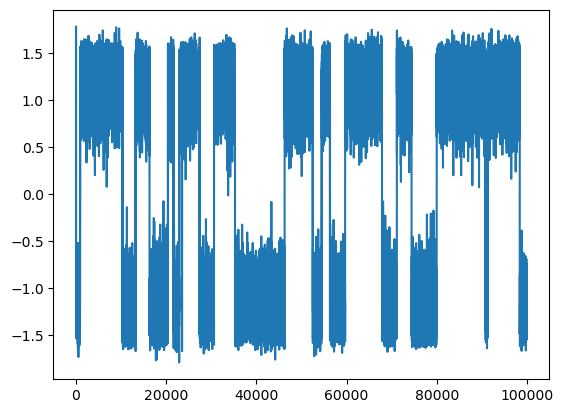

In [14]:
# trajectory data projected on the second principal component
traj_projected = [np.dot(evecs[1], vec) for vec in traj]
plt.figure()
plt.plot(traj_projected)
plt.show()

## 2.1 - Potential visualization

In [28]:
# original function
def fzpot(r):
    x = r[0]
    y = r[1]
    f = (
        5.0 * np.exp(-0.2 * (x + 3.0 * (y + 3.0)) ** 2) / (1.0 + np.exp(x - 3.0))
        + 5.0 * np.exp(-0.2 * (x + 3.0 * (y - 3.0)) ** 2) / (1.0 + np.exp(-x - 3.0))
        - 3.0 * np.exp(-0.01 * (x + 5.0) ** 2 - 0.2 * (y + 5) ** 2)
        - 3.0 * np.exp(-0.01 * (x - 5.0) ** 2 - 0.2 * (y - 5) ** 2)
        + 3.0 * np.exp(-0.01 * (x**2 + y**2))
        + (x**4 + y**4) / 20480.0
    )

    return f

def in_A(r):
    return (r[0] < -4.0) and (r[1] < -3.0)

def in_B(r):
    return (r[0] > 4.0) and (r[1] > 3.0)

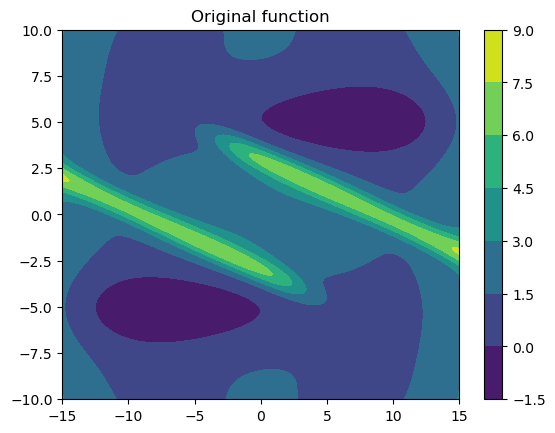

In [29]:
x = np.linspace(-15, 15, 1000)
y = np.linspace(-10, 10, 1000)

X, Y = np.meshgrid(x,y)

# original function
V = fzpot((X,Y))
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, V)
cbar = fig.colorbar(cs)
plt.title('Original function')
plt.show()


## 2.2 - Trajectory data

In [30]:
dt = .05
beta = 1.5
gamma = 1.0
lgamma = 1.0
m = 1.0
c1 = np.exp(-lgamma * dt / 2.0)
c2 = np.sqrt((1.0 - (c1 * c1)) / beta)
lc = np.array([c1, c2])

traj = []

x = np.random.uniform(-15,15)
y = np.random.uniform(-10,10)
r = np.array([x, y])
v = np.array(
[
np.sqrt(1.0 / beta) * rng.standard_normal(),
np.sqrt(1.0 / beta) * rng.standard_normal(),
]
)
sum_Ekin = 0.0
count = 0
scale = np.sqrt(1.0 / beta / Ekin(v))
v = v * scale
f = np.array([-Vpot_dx(r), -Vpot_dy(r)])
for _ in range(10):
    for _ in range(10**4):
        for _ in range(10**2):
            r, v, f = mdstep(r, v, f, dt, lc)
            count = count + 1
            sum_Ekin = sum_Ekin + Ekin(v)
        traj.append(r)
    print(f"x = {r[0]:.3f}, y = {r[1]:.3f}, average beta = {1.0/(sum_Ekin/count):.3f}, A = {in_A(r)}, B = {in_B(r)}")

x = -0.802, y = -0.916, average beta = 1.496, A = False, B = False
x = 0.528, y = -0.134, average beta = 1.493, A = False, B = False
x = 1.151, y = -1.499, average beta = 1.495, A = False, B = False
x = -1.565, y = 1.841, average beta = 1.497, A = False, B = False
x = 1.231, y = -0.729, average beta = 1.498, A = False, B = False
x = -0.969, y = -1.707, average beta = 1.498, A = False, B = False
x = -0.844, y = -0.333, average beta = 1.498, A = False, B = False
x = 1.399, y = -2.480, average beta = 1.499, A = False, B = False
x = -0.930, y = 1.583, average beta = 1.500, A = False, B = False
x = 1.654, y = -2.945, average beta = 1.500, A = False, B = False


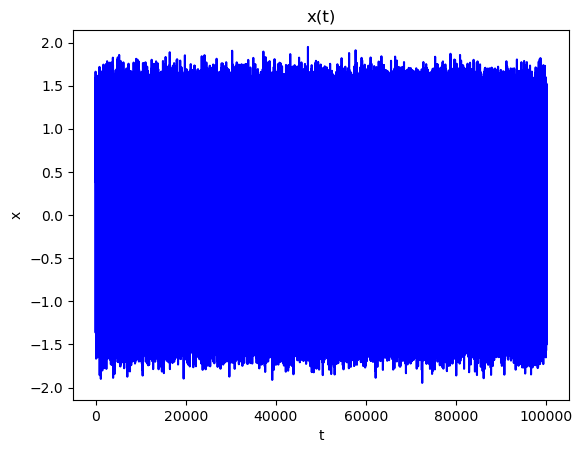

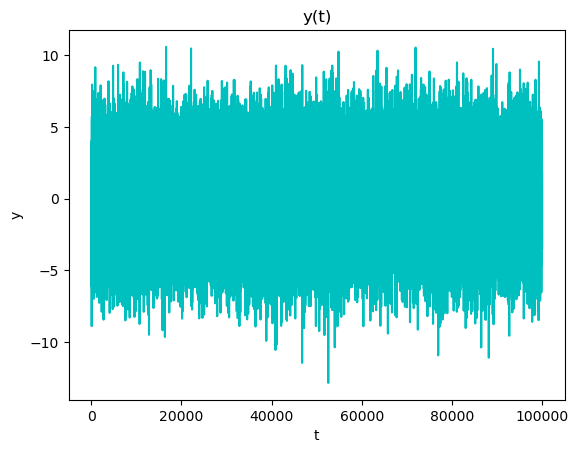

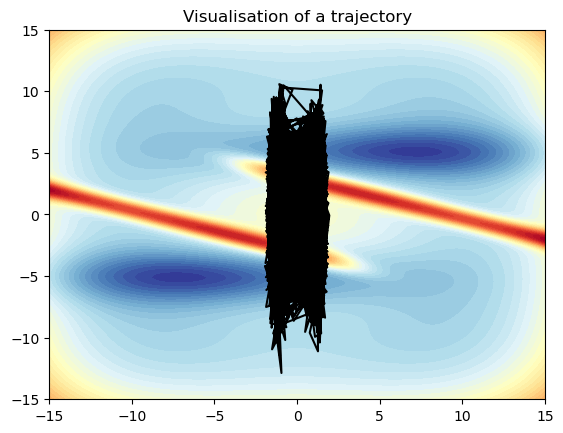

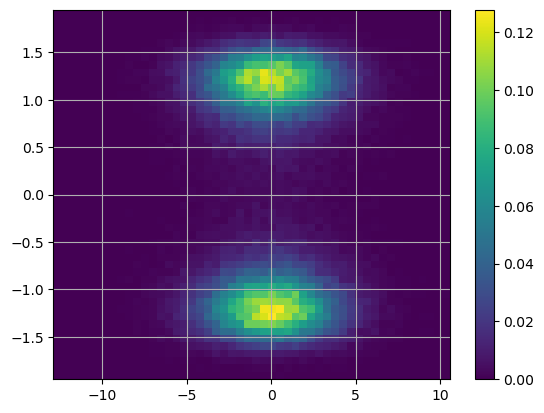

In [23]:
traj = np.array(traj)

# Plot x and y as a function of time
plt.figure()
plt.plot(traj[:, 0], color='b')
plt.xlabel('t')
plt.ylabel('x')
plt.title('x(t)')
plt.show()

plt.figure()
plt.plot(traj[:, 1], color='c')
plt.xlabel('t')
plt.ylabel('y')
plt.title('y(t)')
plt.show


# Visualising trajectory
x = np.linspace(-15, 15, 1000)
y = np.linspace(-15, 15, 1000)

X, Y = np.meshgrid(x,y)
V = fzpot((X,Y))
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, V, levels=50, cmap='RdYlBu_r')
ax.plot(traj[:, 0], traj[:, 1], color='k')
plt.title('Visualisation of a trajectory')
plt.show()

# Distribution of points in the xy-plane ## TODO: strange distribution
H, y_edges, x_edges = np.histogram2d(traj[:, 0], traj[:, 1], bins=50, density=True)
fig, ax = plt.subplots()
cs = ax.pcolormesh(x_edges, y_edges, H)
cbar = fig.colorbar(cs)

ax.grid()
plt.show()


## 2.3 PCA

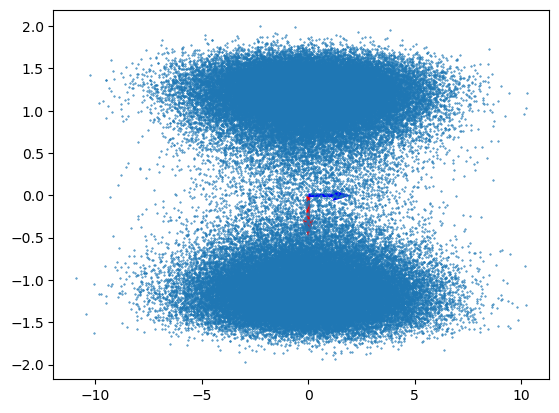

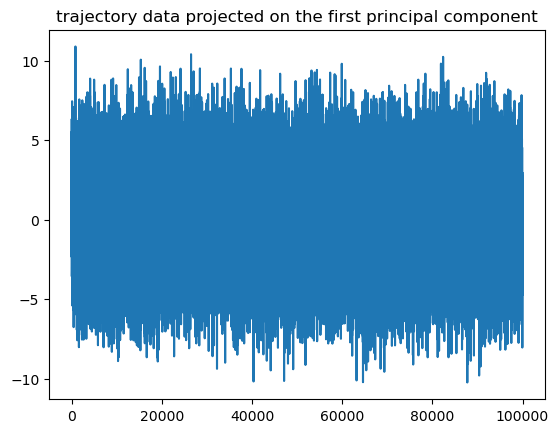

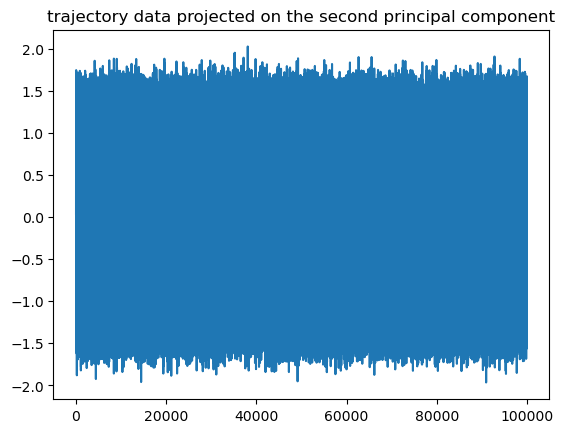

In [31]:
traj_reduced, evecs = pca(traj, 2)
origin = np.array([[0.0, 0.0], [0.0, 0.0]])

# Visualising principal components
plt.figure()
plt.quiver(*origin, evecs[:,0]*2, evecs[:,1]/2, angles='xy', scale_units='xy', scale=1, color=['r','b'])
plt.plot(traj_reduced[:,0], traj_reduced[:,1], 'o', markersize=0.5, markerfacecolor='none')


# trajectory data projected on the first principal component
traj_projected = [np.dot(evecs[0], vec) for vec in traj]
plt.figure()
plt.title("trajectory data projected on the first principal component")
plt.plot(traj_projected)
plt.show()

# trajectory data projected on the second principal component
traj_projected = [np.dot(evecs[1], vec) for vec in traj]
plt.figure()
plt.title("trajectory data projected on the second principal component")
plt.plot(traj_projected)
plt.show()

Q: Can you identify the transition between state A and B in this projection?

A: No because even though the time-series of the position varies the most along this direction (shown by blue arrow), the system's potential only changes minimally. 
No because the time-series of the position varies a lot on both axes (shown by blue and red arrow).